<h1>
    Q.1 Modeling 
</h1>

<h3>Skill:</h3>
<ul>
    <li>Player 1 skill: $s_1$</li>
    <li>Player 2 skill: $s_2$</li>
</ul>
Where: $s_1 \sim \mathcal{N}(\mu_1,\,\sigma^{2}_1)$

Where: $s_2 \sim \mathcal{N}(\mu_2,\,\sigma^{2}_2)$

<h3>Game outcome:</h3>
<ul>
    <li>$t = s_1 - s_2$</li>
</ul>
Where: $t \sim \mathcal{N}(\mu_t = s_1 - s_2,\,\sigma^{2}_t)$

<h3>Game result:</h3>
<ul>
    <li>If player 1 wins: $y = 1$</li>
    <li>If player 2 wins: $y = -1$</li>
</ul>

<h3>Bayesian model:</h3>
<ul>
    <li>$P(s_1, s_2, t, y) = P(y|t) \cdot P(t|s_1, s_2) \cdot P(s_1) \cdot P(s_2)$</li>
</ul>
Where: 
<ul>
    <li>$P(y|t)$ Game result given game outcome</li>
    <li>$P(t|s_1, s_2)$ Game outcome given player skills</li>
    <li>$P(s_1)$ and $P(s_2)$ Player skill priors</li>
</ul>

<h3>Hyperparameters:</h3>
<ul>
    <li>Player 1: $\mu_1$ and $\sigma^{2}_1$</li>
    <li>Player 2: $\mu_2$ and $\sigma^{2}_2$</li>
    <li>Unpredictability of the game outcome: $\sigma^{2}_t$</li>
</ul>

<h1>
    Q.2 Bayesian Network
</h1>

$s_1$ and $s_2$ influences $t$ 

$t$ then influences $y$

<h1>
    Q.3 Computing with the model
</h1>

In [4]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm

<h3>Initialization</h3>

<h3>$p(s1, s2|t, y)$ - Full conditional distribution of the skills</h3>

In [5]:
# Gaussian-Gaussian Bayesian Update
def update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples):
    A = np.array([[1, -1]])
    mu_prior = np.array([[s1_mean], [s2_mean]])
    sigma_prior = np.array([[s1_var, 0], [0, s2_var]])
        
    sigma_posterior = np.linalg.inv(np.linalg.inv(sigma_prior) + (t_var)**(-1) * (A.T @ A))
    mu_posterior = sigma_posterior @ (np.linalg.inv(sigma_prior) @ mu_prior + t_var**(-1) * A.T * t_samples)

    return mu_posterior, sigma_posterior

mean_s1 = 1
var_s1 =  1
mean_s2 = -1
var_s2 = 4
var_t = 5
t_obs = 3

mu_posterior, Sigma_posterior = update_skills(mean_s1,var_s1,mean_s2,var_s2,var_t,t_obs)
print("Posterior mean of s1 and s2:", mu_posterior)
print("Posterior covariance of s1 and s2:", Sigma_posterior)

Posterior mean of s1 and s2: [[ 1.1]
 [-1.4]]
Posterior covariance of s1 and s2: [[0.9 0.4]
 [0.4 2.4]]


# <h3>$p(t|s1, s2, y)$ - Full conditional distribution of the outcome</h3>

In [6]:
def conditional_distribution_t(s1, s2, y):
    t_mean = s1 - s2
    a, b = 0, 0
    
    if y == 1:
        a = 0
        b = np.inf
    else:
        a = -np.inf
        b = 0
    return t_mean, a, b

s1 = 2
s2 = 1
t_var = 5
y = 1

mu, a, b = conditional_distribution_t(s1, s2, y)

print(f"Parameters for p(t|s1, s2, y):\nmu_t: {mu}, sigma^2: {round(t_var,4)} \nBounds: [{a}, {b}]")

Parameters for p(t|s1, s2, y):
mu_t: 1, sigma^2: 5 
Bounds: [0, inf]


<h3>$p(y=1)$ - Marginal probability that Player 1 wins the game</h3>

In [7]:
# Marginal Probability that Player 1 Wins
def compute_marginal_probability(mu_t, var_s1, var_s2, var_t):
    sigma_t = np.sqrt(var_s1 + var_s2 + var_t)
    probability_y1 = 1 - norm.cdf(0, mu_t, sigma_t)
    
    return probability_y1

var_s1 =  1
var_s2 =  4
mu_t = 2
t_var = 5

prob_y1 = compute_marginal_probability(mu_t, var_s1, var_s2, t_var)
print(f"Marginal probability that Player 1 wins (p(y=1)): {round(prob_y1,4)}")
print(f"Marginal probability that Player 2 wins (p(y=-1)): {round(1-prob_y1,4)}")


Marginal probability that Player 1 wins (p(y=1)): 0.7365
Marginal probability that Player 2 wins (p(y=-1)): 0.2635


<h1>
    Q.4  A first Gibbs sampler
</h1>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time

def gibbs_sampling_trueskill(N, N_burn_in, match_properties):
    s1_mean = match_properties["s1_mean"]
    s1_var = match_properties["s1_var"]
    s1_std = np.sqrt(s1_var)
    
    s2_mean = match_properties["s2_mean"]
    s2_var = match_properties["s2_var"]
    s2_std = np.sqrt(s2_var)


    t_var = match_properties["t_var"]
    
    y = match_properties["y"]

    
    s1_samples, s2_samples, t_samples = np.zeros(N), np.zeros(N), np.zeros(N)
    s1_samples[0] = (np.random.normal(s1_mean, s1_std))
    s2_samples[0] = (np.random.normal(s2_mean, s2_std))
    
    for i in range(N - 1):
        t_mean = s1_samples[i] - s2_samples[i]
        t_mean, a, b = conditional_distribution_t(s1_samples[i], s2_samples[i], y)
        t_samples[i+1] = truncnorm.rvs(a = (a-t_mean)/np.sqrt(t_var), b = (b-t_mean)/np.sqrt(t_var), loc=t_mean, scale=np.sqrt(t_var))
    
        mu_posterior, sigma_posterior = update_skills(s1_mean, s1_var, s2_mean, s2_var, t_var, t_samples[i]) 
    
        s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T
    
    return np.array(s1_samples[N_burn_in:]), np.array(s2_samples[N_burn_in:]), np.array(t_samples[N_burn_in:])
    
start_time = time.time()
s1_mean = 25
s1_var = (25/3)
s2_mean = 25
s2_var = (25/3)
t_var = (25/6)
y = 1

match_properties = {
    "s1_mean": s1_mean,
    "s1_var": s1_var,
    "s2_mean": s2_mean,
    "s2_var": s2_var,
    "t_var": t_var,
    "y": y
}


N = 1000
N_burn_in = int(np.sqrt(N))

s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


Elapsed time:  0.5242290496826172


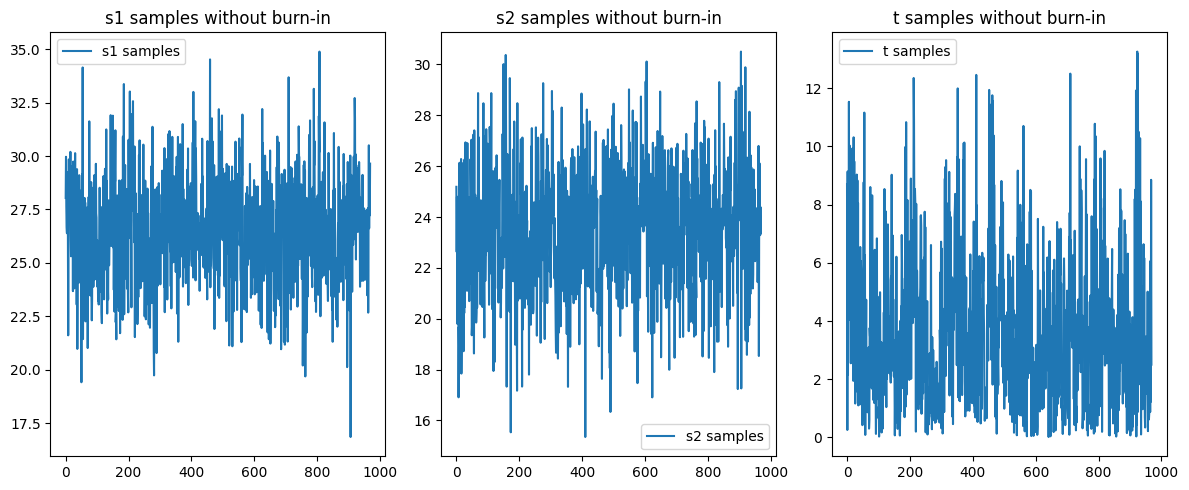

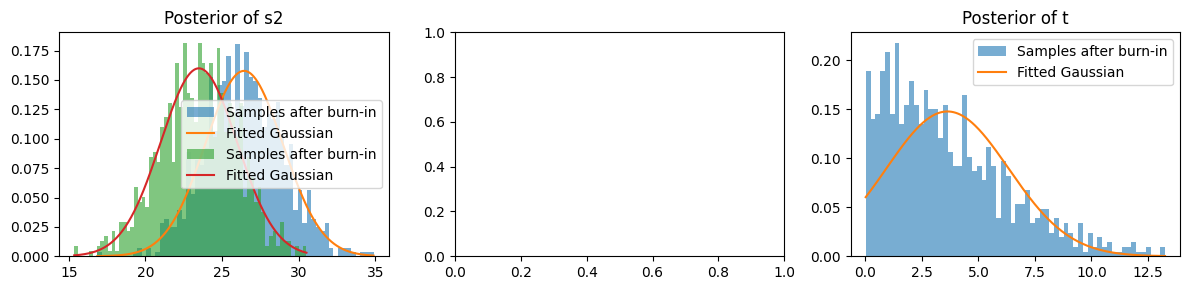

In [36]:
def plot_samples(s1_samples, s2_samples, t_samples):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].plot(s1_samples, label="s1 samples")
    ax[0].set_title("s1 samples without burn-in")
    ax[0].legend()
    
    ax[1].plot(s2_samples, label="s2 samples")
    ax[1].set_title("s2 samples without burn-in")
    ax[1].legend()

    ax[2].plot(t_samples, label="t samples")
    ax[2].set_title("t samples without burn-in")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

def plot_histogram_with_fitted_gaussian(samples, title, ax):
    mu = np.mean(samples)
    sigma = np.std(samples)
    ax.hist(samples, bins=2*int(np.sqrt(len(samples))), density=True, alpha=0.6, label="Samples after burn-in")
    ax.plot(np.linspace(min(samples), max(samples), 400), 
            norm.pdf(np.linspace(min(samples), max(samples), 400), mu, sigma), 
             label="Fitted Gaussian")
    ax.legend()
    ax.set_title(title)

plot_samples(s1_samples, s2_samples, t_samples)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
plot_histogram_with_fitted_gaussian(s1_samples, "Posterior of s1", ax[0])
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s2", ax[0])
plot_histogram_with_fitted_gaussian(t_samples, "Posterior of t", ax[2])
plt.tight_layout()
plt.show()

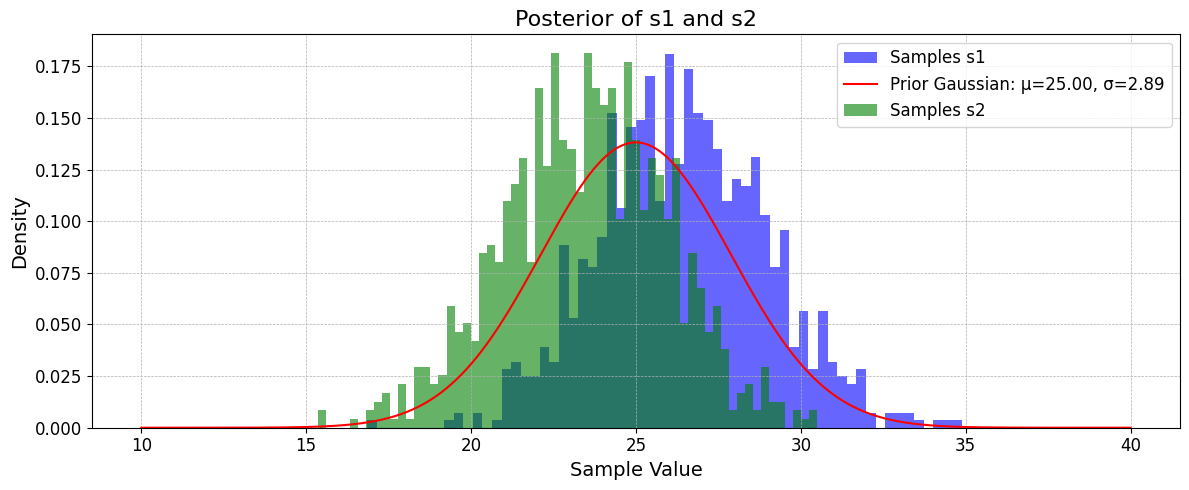

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_histogram_with_fitted_gaussian(samples, title, ax, i, color="blue"):
    # Calculate mean and standard deviation
    mu = (25)
    sigma = ((25/3)**0.5)
    
    # Plot histogram with a better binning strategy and specified color
    n_bins = 2*int(np.sqrt(len(samples)))
    ax.hist(samples, bins=n_bins, density=True, alpha=0.6, color=color, label=f"Samples s{i}")
    
    # Plot the fitted Gaussian
    if i == 1:
        x_vals = np.linspace(10, 40, 400)
        ax.plot(x_vals, norm.pdf(x_vals, mu, sigma), color="red", label=f"Prior Gaussian: μ={mu:.2f}, σ={sigma:.2f}")
    
    # Enhance the visual appeal
    ax.set_title(title, fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Sample Value", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_histogram_with_fitted_gaussian(s1_samples, "", ax, 1, color="blue")
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s1 and s2", ax, 2, color="green")
plt.tight_layout()
plt.savefig("post_n_samples.png")
plt.show()

TypeError: plot_histogram_with_fitted_gaussian() missing 1 required positional argument: 'i'

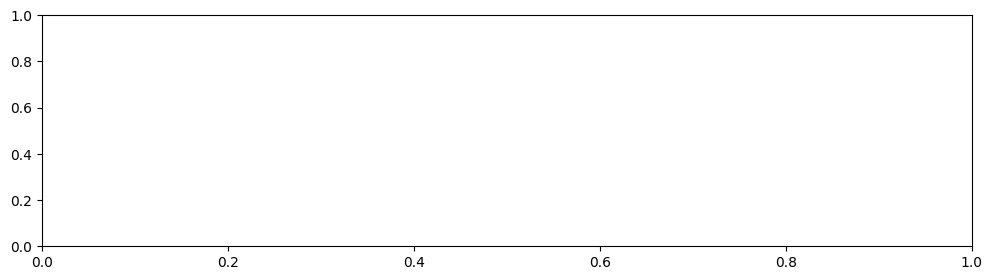

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
plot_histogram_with_fitted_gaussian(s1_samples, "1", ax)
plot_histogram_with_fitted_gaussian(s2_samples, "Posterior of s1 and s2, N = 10000", ax)

plt.savefig("post_n_10000.png")

In [12]:
mu1 = np.mean(s1_samples)
mu1

28.001149275839477

In [13]:
sigma1 = np.std(s1_samples)
sigma1

2.7866830082810696

In [14]:
mu2 = np.mean(s2_samples)
mu2

22.08051431874803

In [15]:
sigma2 = np.std(s2_samples)
sigma2

2.6008479082726157

In [16]:
mu3 = np.mean(t_samples)
mu3

7.546464623234774

In [17]:
sigma3 = np.var(t_samples[2000:])
sigma3

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

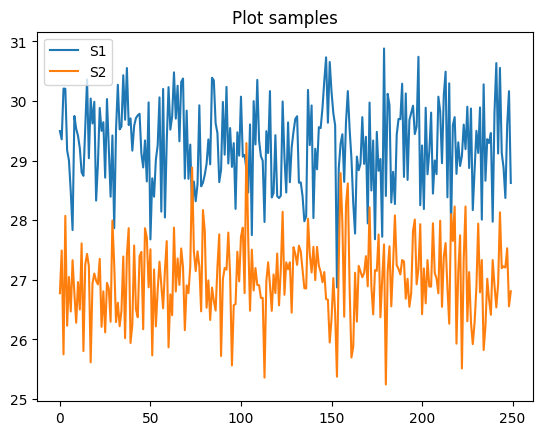

In [45]:
plt.plot(s1_samples, label="S1")
plt.plot(s2_samples, label="S2")
plt.title("Plot samples")
plt.legend()
plt.show()

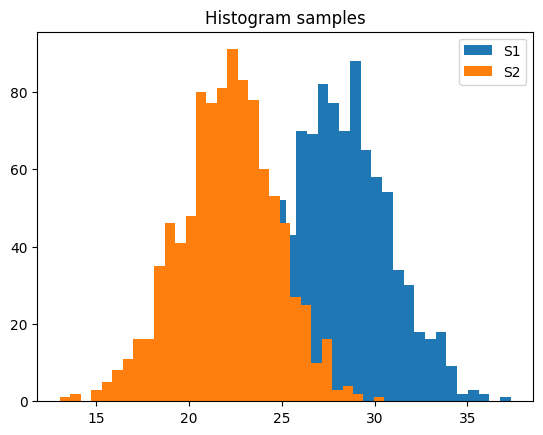

In [19]:
plt.hist(s1_samples, bins = int(N**0.5), label="S1")
plt.hist(s2_samples, bins = int(N**0.5), label="S2")
plt.title("Histogram samples")
plt.legend()
plt.show()

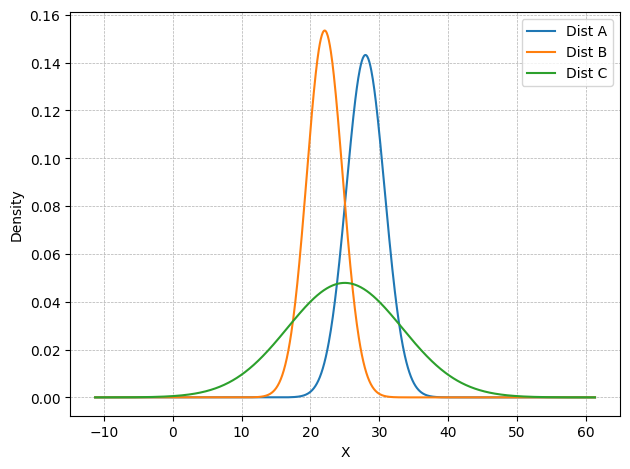

In [20]:
from scipy.stats import norm

def plot_normal_distributions(means, stds, labels=None, title="", xlabel="X", ylabel="Density"):
    """
    Plot multiple normal distributions overlaying each other.

    Parameters:
    - means: List of means for the normal distributions.
    - stds: List of standard deviations for the normal distributions.
    - labels: List of labels for the distributions.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    """
    
    # Create a range of x values to evaluate the distributions
    x = np.linspace(min(means) - 4 * max(stds), max(means) + 4 * max(stds), 1000)
    
    # If labels are not provided, create default labels
    if not labels:
        labels = [f"Dist {i}" for i in range(len(means))]
    
    # Plot each distribution
    for mean, std, label in zip(means, stds, labels):
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, label=label)
    
    # Set the title, labels, and display the legend
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Sample distributions
sample_means = [mu1, mu2, 25]
sample_stds = [sigma1, sigma2, (25/3)]
sample_labels = ["Dist A", "Dist B", "Dist C"]

# Plot the sample distributions
plot_normal_distributions(sample_means, sample_stds, sample_labels)


<h1>
    Q.5  Assumed Density Filtering
</h1>

In [32]:
import pandas as pd

seriea_df = pd.read_csv('SerieA.csv')

# Extract all unique teams
teams = list(set(seriea_df['team1'].unique()) | set(seriea_df['team2'].unique()))

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = (25/3)**2

team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}
team_skills


{'Roma': {'mean': 25, 'variance': 69.44444444444446},
 'Genoa': {'mean': 25, 'variance': 69.44444444444446},
 'Frosinone': {'mean': 25, 'variance': 69.44444444444446},
 'Napoli': {'mean': 25, 'variance': 69.44444444444446},
 'Milan': {'mean': 25, 'variance': 69.44444444444446},
 'Cagliari': {'mean': 25, 'variance': 69.44444444444446},
 'Empoli': {'mean': 25, 'variance': 69.44444444444446},
 'Sassuolo': {'mean': 25, 'variance': 69.44444444444446},
 'Lazio': {'mean': 25, 'variance': 69.44444444444446},
 'Fiorentina': {'mean': 25, 'variance': 69.44444444444446},
 'Bologna': {'mean': 25, 'variance': 69.44444444444446},
 'Spal': {'mean': 25, 'variance': 69.44444444444446},
 'Inter': {'mean': 25, 'variance': 69.44444444444446},
 'Juventus': {'mean': 25, 'variance': 69.44444444444446},
 'Atalanta': {'mean': 25, 'variance': 69.44444444444446},
 'Chievo': {'mean': 25, 'variance': 69.44444444444446},
 'Sampdoria': {'mean': 25, 'variance': 69.44444444444446},
 'Parma': {'mean': 25, 'variance': 69

In [34]:
N = 250
N_burn_in = 10

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']
    
    # Skip the match if it's a draw
    if score1 == score2:
        continue
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = (25/6)
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


[('Juventus', 26.47866774563041),
 ('Napoli', 26.421705458639334),
 ('Torino', 25.843065956265907),
 ('Atalanta', 25.77347792636307),
 ('Inter', 25.658411172178663),
 ('Milan', 25.647669273090568),
 ('Roma', 25.28074900792215),
 ('Lazio', 25.244509884270816),
 ('Udinese', 24.355842547686404),
 ('Sampdoria', 24.281634810586308),
 ('Spal', 24.166313749522278),
 ('Empoli', 24.04314017875171),
 ('Genoa', 23.948899217333693),
 ('Bologna', 23.935206554784713),
 ('Parma', 23.77874881346179),
 ('Cagliari', 23.75410091242377),
 ('Sassuolo', 23.704423177482322),
 ('Fiorentina', 23.541549965864913),
 ('Frosinone', 22.23365678428927),
 ('Chievo', 21.82683130355878)]

In [ ]:
plt.figure(figsize=(12, 8))

for team in team_skills.keys():
    mean = team_skills[team]['mean']
    std_dev = np.sqrt(team_skills[team]['variance'])
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    plt.plot(x, norm.pdf(x, mean, std_dev), label=team)

plt.title('Skill Levels of All Teams')
plt.xlabel('Skill Level')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()
plt.show()

<h1>
    Q.6 Using the model for predictions
</h1>

In [ ]:
N = 1000
N_burn_in = 100

match_predictions = []

# Prediction function
def predict_winner(s1_mean, s1_var, s2_mean, s2_var):
    diff_mean = s1_mean - s2_mean
    diff_var = s1_var + s2_var
    # Compute the probability that Player 1's skill is greater than Player 2's skill
    return 1 if compute_marginal_probability(diff_mean, s1_var, s2_var, diff_var) > 0.5 else -1

correct_predictions = 0
total_predictions = 0

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']

    # Skip the match if it's a draw
    if score1 == score2:
        continue

    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Predict the winner based on current skill estimates
    prediction = predict_winner(
        team_skills[team1]['mean'], team_skills[team1]['variance'],
        team_skills[team2]['mean'], team_skills[team2]['variance']
    )

    # Append match details and prediction to the list
    match_predictions.append({
        "team1": team1,
        "team2": team2,
        "actual_outcome": y,
        "predicted_outcome": prediction
    })
    
    
    # Compare prediction to actual result
    if prediction == y:
        correct_predictions += 1

    total_predictions += 1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 1
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Compute prediction rate
prediction_rate = correct_predictions / total_predictions

prediction_rate

<h1>
    Q.9 Your own data
</h1>

In [127]:
import pandas as pd

# Read the CSV file into a DataFrame
df_cs = pd.read_csv('results.csv')

# Convert the 'date' column to datetime format
df_cs['date'] = pd.to_datetime(df_cs['date'])

# Filter the data for 2015 and 2016
df_2015 = df_cs[(df_cs['date'].dt.year == 2016) & (df_cs['date'].dt.month.isin([1,2,3,4,5,6]))]
df_2016 = df_cs[(df_cs['date'].dt.year == 2016) & (df_cs['date'].dt.month.isin([7,8,9,10,11,12]))]

# Extract the specified columns for both datasets
cols = ['team_1', 'team_2', 'result_1', 'result_2']
df_2015 = df_2015[cols]
df_2016 = df_2016[cols]

# Drop rows with question marks for both datasets
df_2015 = df_2015[~((df_2015['team_1'] == '?') | (df_2015['team_2'] == '?'))]
df_2016 = df_2016[~((df_2016['team_1'] == '?') | (df_2016['team_2'] == '?'))]

# Get the intersection of teams
#common_teams = teams_2015 & teams_2016

# Extract unique teams from df_2016
teams_2016 = set(df_2016['team_1'].unique()) | set(df_2016['team_2'].unique())

# Filter df_2015 based on teams that exist in df_2016
df_2015 = df_2015[df_2015['team_1'].isin(teams_2016) & df_2015['team_2'].isin(teams_2016)]


# Filter the datasets based on the intersection of teams
#df_2015 = df_2015[df_2015['team_1'].isin(common_teams) & df_2015['team_2'].isin(common_teams)]
#df_2016 = df_2016[df_2016['team_1'].isin(common_teams) & df_2016['team_2'].isin(common_teams)]

df_2015 = df_2015.reset_index(drop=True)
df_2016 = df_2016.reset_index(drop=True)


In [128]:
# Extract all unique teams
teams = list(teams_2016)

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = (25/3)**2
team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}

In [129]:
team_skills

{'HUEHUE': {'mean': 25, 'variance': 69.44444444444446},
 'ENCE': {'mean': 25, 'variance': 69.44444444444446},
 'onestop': {'mean': 25, 'variance': 69.44444444444446},
 'Rascal Jester': {'mean': 25, 'variance': 69.44444444444446},
 'Infinity': {'mean': 25, 'variance': 69.44444444444446},
 'Threats': {'mean': 25, 'variance': 69.44444444444446},
 'GODSENT Academy': {'mean': 25, 'variance': 69.44444444444446},
 'Rebellion': {'mean': 25, 'variance': 69.44444444444446},
 'AC-130': {'mean': 25, 'variance': 69.44444444444446},
 'iNETKOXTV': {'mean': 25, 'variance': 69.44444444444446},
 'hmm': {'mean': 25, 'variance': 69.44444444444446},
 'Wild': {'mean': 25, 'variance': 69.44444444444446},
 '3 NEW 2 OLD': {'mean': 25, 'variance': 69.44444444444446},
 'iGame.com': {'mean': 25, 'variance': 69.44444444444446},
 'WE GOT GAME': {'mean': 25, 'variance': 69.44444444444446},
 'Complexity': {'mean': 25, 'variance': 69.44444444444446},
 'T5': {'mean': 25, 'variance': 69.44444444444446},
 'HellRaisers': 

In [130]:
N = 100
N_burn_in = 10

for index, row in df_2015.iterrows():
    team1, team2, score1, score2 = row['team_1'], row['team_2'], row['result_1'], row['result_2']
    if (index % 25 == 0):
        print(index)
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 25/6
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

0


C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900


[('X', 33.87709892341943),
 ('eXtatus', 31.452661946807478),
 ('Bravado', 30.138509716762407),
 ('Space Jam', 27.561917017764294),
 ('Spirit', 26.57010250864743),
 ('Kinguin', 26.237327969812622),
 ('PRIDE', 25.9575781525149),
 ('Space Soldiers', 25.886337862566126),
 ('LDLC', 25.828136043276437),
 ('LowLandLions', 25.81136641728371),
 ('Tricked', 25.776212138598602),
 ('Luminosity', 25.749032198150786),
 ('TYLOO', 25.713958227586463),
 ('deadweight', 25.68671736483068),
 ('MK', 25.317414203488944),
 ('Astralis', 25.221803086451807),
 ('Natus Vincere', 25.22104162862347),
 ('HUEHUE', 25),
 ('onestop', 25),
 ('Rascal Jester', 25),
 ('Infinity', 25),
 ('GODSENT Academy', 25),
 ('Rebellion', 25),
 ('AC-130', 25),
 ('hmm', 25),
 ('Wild', 25),
 ('3 NEW 2 OLD', 25),
 ('iGame.com', 25),
 ('T5', 25),
 ('VG.Potential', 25),
 ('ex-31337', 25),
 ('China', 25),
 ('TShow', 25),
 ('Overpowered', 25),
 ('Blight', 25),
 ('Parallax', 25),
 ('Wyvern', 25),
 ('Crowns', 25),
 ('VwS', 25),
 ('Awsomniac', 2

In [94]:
team_skills

{'ENCE': {'mean': 23.787811479395234, 'variance': 0.7089008390890715},
 'dream[S]cape': {'mean': 21.24367178174087, 'variance': 18.237377911726757},
 'LDLC Blue': {'mean': 24.75176155339245, 'variance': 0.7812411732108328},
 'FMESPORTS': {'mean': 19.735713838537325, 'variance': 3.235180425231971},
 'Threats': {'mean': 21.212069806640045, 'variance': 10.211309012693796},
 'Binary Dragons': {'mean': 19.778916500725373, 'variance': 2.337368699786054},
 'MOTV': {'mean': 30.788999872804112, 'variance': 45.92795390652769},
 'MVP Project': {'mean': 19.183535428928263, 'variance': 7.296540739573733},
 'Exertus fe': {'mean': 24.669535636327712, 'variance': 7.147476483137568},
 'Gambit': {'mean': 24.27509142025289, 'variance': 2.588358023239456},
 'E-frag.net': {'mean': 24.356592088985206, 'variance': 0.5312038451996663},
 'Method': {'mean': 21.107670606089165, 'variance': 1.436573668245907},
 'Platinium': {'mean': 23.12925844104746, 'variance': 1.6008738359914938},
 'Obey.Alliance': {'mean': 24

In [131]:
N = 100
N_burn_in = 10

match_predictions = []

# Prediction function
def predict_winner(s1_mean, s1_var, s2_mean, s2_var):
    diff_mean = s1_mean - s2_mean
    diff_var = s1_var + s2_var
    # Compute the probability that Player 1's skill is greater than Player 2's skill
    return 1 if compute_marginal_probability(diff_mean, s1_var, s2_var, diff_var) > 0.5 else -1

correct_predictions = 0
total_predictions = 0

for index, row in df_2016.iterrows():
    team1, team2, score1, score2 = row['team_1'], row['team_2'], row['result_1'], row['result_2']

    # Skip the match if it's a draw
    if score1 == score2:
        continue

    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Predict the winner based on current skill estimates
    prediction = predict_winner(
        team_skills[team1]['mean'], team_skills[team1]['variance'],
        team_skills[team2]['mean'], team_skills[team2]['variance']
    )

    # Append match details and prediction to the list
    match_predictions.append({
        "team1": team1,
        "team2": team2,
        "actual_outcome": y,
        "predicted_outcome": prediction
    })
    
    
    # Compare prediction to actual result
    if prediction == y:
        correct_predictions += 1

    total_predictions += 1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 25/6
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Compute prediction rate
prediction_rate = correct_predictions / total_predictions

prediction_rate

C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


0.5865715691096901

In [96]:
match_predictions

[{'team1': 'ALTERNATE aTTaX',
  'team2': 'Torpedo',
  'actual_outcome': -1,
  'predicted_outcome': 1},
 {'team1': 'Natus Vincere',
  'team2': 'Virtus.pro',
  'actual_outcome': 1,
  'predicted_outcome': 1},
 {'team1': 'VG.CyberZen',
  'team2': 'New4',
  'actual_outcome': 1,
  'predicted_outcome': 1},
 {'team1': 'VG.CyberZen',
  'team2': 'New4',
  'actual_outcome': -1,
  'predicted_outcome': 1},
 {'team1': 'AllGamers',
  'team2': 'HG',
  'actual_outcome': -1,
  'predicted_outcome': 1},
 {'team1': 'AllGamers',
  'team2': 'HG',
  'actual_outcome': 1,
  'predicted_outcome': -1},
 {'team1': 'mousesports',
  'team2': 'NiP',
  'actual_outcome': -1,
  'predicted_outcome': -1},
 {'team1': 'mousesports',
  'team2': 'NiP',
  'actual_outcome': 1,
  'predicted_outcome': -1},
 {'team1': 'mousesports',
  'team2': 'NiP',
  'actual_outcome': -1,
  'predicted_outcome': -1},
 {'team1': 'AGG',
  'team2': 'Planetkey',
  'actual_outcome': 1,
  'predicted_outcome': 1},
 {'team1': 'AGG',
  'team2': 'Planetkey'

In [63]:
df_2016

,team_1,team_2,result_1,result_2
45007,CLG,Vexed,16,13
45008,CLG,Vexed,3,16
45009,CLG,Vexed,16,13
45011,Cloud9,Renegades,19,16
45012,Cloud9,Renegades,16,14
...,...,...,...,...
45455,FlipSid3,SK,3,16
45456,FlipSid3,SK,21,18
45457,FlipSid3,SK,16,21
45458,Envy,Dignitas,16,10


<h1>Q10 - Include draws</h1>

In [125]:
import pandas as pd

seriea_df = pd.read_csv('SerieA.csv')

# Extract all unique teams
teams = list(set(seriea_df['team1'].unique()) | set(seriea_df['team2'].unique()))

# Initialize each team's skills with a common prior
initial_mean = 25
initial_variance = (25/3)**2

team_skills = {team: {'mean': initial_mean, 'variance': initial_variance} for team in teams}
team_skills


{'Roma': {'mean': 25, 'variance': 69.44444444444446},
 'Genoa': {'mean': 25, 'variance': 69.44444444444446},
 'Frosinone': {'mean': 25, 'variance': 69.44444444444446},
 'Napoli': {'mean': 25, 'variance': 69.44444444444446},
 'Milan': {'mean': 25, 'variance': 69.44444444444446},
 'Cagliari': {'mean': 25, 'variance': 69.44444444444446},
 'Empoli': {'mean': 25, 'variance': 69.44444444444446},
 'Sassuolo': {'mean': 25, 'variance': 69.44444444444446},
 'Lazio': {'mean': 25, 'variance': 69.44444444444446},
 'Fiorentina': {'mean': 25, 'variance': 69.44444444444446},
 'Bologna': {'mean': 25, 'variance': 69.44444444444446},
 'Spal': {'mean': 25, 'variance': 69.44444444444446},
 'Inter': {'mean': 25, 'variance': 69.44444444444446},
 'Juventus': {'mean': 25, 'variance': 69.44444444444446},
 'Atalanta': {'mean': 25, 'variance': 69.44444444444446},
 'Chievo': {'mean': 25, 'variance': 69.44444444444446},
 'Sampdoria': {'mean': 25, 'variance': 69.44444444444446},
 'Parma': {'mean': 25, 'variance': 69

In [122]:
N = 250
N_burn_in = 10

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']
    
    # Check the values
    if score1 > score2:
        y = 1
    elif score1 == score2:
        if np.abs(team_skills[team1]['mean'] - team_skills[team2]['mean']) > 2:
            if team_skills[team1]['mean'] > team_skills[team2]['mean']:
                y = -1
            else:
                y = 1
            
    else:
        y = -1
            
        
        
    # Determine the outcome (1 if team1 wins, -1 if team2 wins)
    y = 1 if score1 > score2 else -1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = (25/6)
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Sort teams by their final skill means to get the ranking
sorted_teams = sorted(team_skills.items(), key=lambda x: x[1]['mean'], reverse=True)

ranked_teams = [(team[0], team[1]['mean']) for team in sorted_teams]
ranked_teams

C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


[('Torino', 27.456927636158653),
 ('Milan', 27.231924524137405),
 ('Inter', 26.900360542921376),
 ('Napoli', 26.78480181219633),
 ('Roma', 26.758941991624877),
 ('Atalanta', 26.466284373661903),
 ('Juventus', 26.43433943904854),
 ('Sampdoria', 26.193837874551626),
 ('Lazio', 25.581248789392543),
 ('Bologna', 24.99951938239339),
 ('Fiorentina', 24.964987793149202),
 ('Udinese', 24.907711750399944),
 ('Cagliari', 24.85564851216297),
 ('Empoli', 24.852160219996602),
 ('Genoa', 24.43370469086852),
 ('Sassuolo', 24.389148399239502),
 ('Parma', 24.3210378343495),
 ('Spal', 24.10377177133432),
 ('Frosinone', 23.98809188185386),
 ('Chievo', 23.519388650540137)]

In [126]:
N = 100
N_burn_in = 10

match_predictions = []

# Prediction function
def predict_winner(s1_mean, s1_var, s2_mean, s2_var):
    diff_mean = s1_mean - s2_mean
    diff_var = s1_var + s2_var
    # Compute the probability that Player 1's skill is greater than Player 2's skill
    if compute_marginal_probability(diff_mean, s1_var, s2_var, diff_var) > 0.50:
        return 1
    else:
        return -1

correct_predictions = 0
total_predictions = 0

for index, row in seriea_df.iterrows():
    team1, team2, score1, score2 = row['team1'], row['team2'], row['score1'], row['score2']

    # Check the values
    if score1 > score2:
        y = 1
    elif score1 == score2:
        if np.abs(team_skills[team1]['mean'] - team_skills[team2]['mean']) > 2:
            if team_skills[team1]['mean'] > team_skills[team2]['mean']:
                y = -1
            else:
                y = 1
            
    else:
        y = -1
    
    # Predict the winner based on current skill estimates
    prediction = predict_winner(
        team_skills[team1]['mean'], team_skills[team1]['variance'],
        team_skills[team2]['mean'], team_skills[team2]['variance']
    )

    # Append match details and prediction to the list
    match_predictions.append({
        "team1": team1,
        "team2": team2,
        "actual_outcome": y,
        "predicted_outcome": prediction
    })
    
    
    # Compare prediction to actual result
    if prediction == y:
        correct_predictions += 1

    total_predictions += 1
    
    # Get the current skill estimates for the two teams
    s1_mean, s1_var = team_skills[team1]['mean'], team_skills[team1]['variance']
    s2_mean, s2_var = team_skills[team2]['mean'], team_skills[team2]['variance']

    t_var = 1
    
    match_properties = {
        "s1_mean": s1_mean,
        "s1_var": s1_var,
        "s2_mean": s2_mean,
        "s2_var": s2_var,
        "t_var": t_var,
        "y": y
    }

    # Use the Gibbs sampler to get posterior skill distributions
    s1_samples, s2_samples, t_samples = gibbs_sampling_trueskill(N, N_burn_in, match_properties)
    
    # Update the skill estimates for the two teams
    team_skills[team1]['mean'], team_skills[team1]['variance'] = np.mean(s1_samples), np.var(s1_samples)
    team_skills[team2]['mean'], team_skills[team2]['variance'] = np.mean(s2_samples), np.var(s2_samples)

# Compute prediction rate
prediction_rate = correct_predictions / total_predictions

prediction_rate

C:\Users\claud\AppData\Local\Temp\ipykernel_20820\890143259.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s1_samples[i+1], s2_samples[i+1] = np.random.multivariate_normal(mu_posterior.flatten(), sigma_posterior, 1).T


0.5736842105263158